In [1]:
import numpy as np

def parse_hmm(fname):
    f = open(fname)
    line=f.readline()
    while line[0]!='#':
        line=f.readline()
    f.readline()
    f.readline()
    f.readline()
    f.readline()
    seq = []
    extras = np.zeros([0,10])
    prob = np.zeros([0,20])
    line = f.readline()
    while line[0:2]!='//':
        lineinfo = line.split()
        seq.append(lineinfo[0])
        probs_ = [2**(-float(lineinfo[i])/1000) if lineinfo[i]!='*' else 0. for i in range(2,22)]
        prob = np.concatenate((prob,np.matrix(probs_)),axis=0)

        line = f.readline()
        lineinfo = line.split()
        extras_ = [2**(-float(lineinfo[i])/1000) if lineinfo[i]!='*' else 0. for i in range(0,10)]
        extras = np.concatenate((extras,np.matrix(extras_)),axis=0)

        line = f.readline()
        assert len(line.strip())==0

        line = f.readline()
    return (''.join(seq),prob,extras)

In [2]:
def parse_pssm(fname):
    f = open(fname)
    # the 4th line should be the start of the PSSM data
    f.readline()
    f.readline()
    f.readline()
    seq = []
    lprob = np.zeros([0,20])
    prob = np.zeros([0,20])
    extra = np.zeros([0,2])
    line = f.readline()
    while len(line.strip())>0:
        lineinfo = line.split()
        seq.append(lineinfo[1])
        lprobs_ = [float(lineinfo[i]) for i in range(2,22)]
        lprob = np.concatenate((lprob,np.matrix(lprobs_)),axis=0)
        probs_ = [float(lineinfo[i])/100 for i in range(22,42)]
        prob = np.concatenate((prob,np.matrix(probs_)),axis=0)
        extras_ = [float(lineinfo[i]) for i in range(42,44)]
        extra = np.concatenate((extra,np.matrix(extras_)),axis=0)
        line = f.readline()

    return (''.join(seq),prob,lprob,extra)

In [3]:
import numpy as np

def calculate_sxgbg_features(evolutionary_profile, X):
    L, _ = evolutionary_profile.shape
    sxgbg_features = np.zeros((L, 400))

    for i in range(1, L + 1):
        for j in range(1, L + 1):
            if i >= 1 and j >= 1 and i <= L and j <= L:
                for l in range(0, min(X + 1, L - max(i, j) + 1)):  # Adjust the loop range
                    if (j - 1) * (X + 1) + l < 400:  # Ensure the index is within bounds
                        sxgbg_value = np.dot(
                            evolutionary_profile[i - 1, :], evolutionary_profile[j - 1, :]
                        )
                        sxgbg_features[i - 1, (j - 1) * (X + 1) + l] = sxgbg_value

    return sxgbg_features

In [4]:
import pandas as pd

In [5]:
data=pd.read_csv('/content/drive/MyDrive/Hdaproject/Benchmark_BinaryML.csv')

In [6]:
import numpy as np

# Create an empty list to store hmm_arr for each PDBid
hmm_matrices = []

for i in data['PDBid']:
  hmm_mat = parse_pssm(f'/content/drive/MyDrive/Hdaproject/Benchmark_PSSM-20230926T090015Z-001/Benchmark_PSSM/{i}.txt')
  hmm_arr = np.array(hmm_mat[1])
  hmm_matrices.append(hmm_arr)
# Add the list of hmm_arr as a new column 'hmm_matrix' in the DataFrame
data['hmm_matrix'] = hmm_matrices

In [7]:
import numpy as np
from sklearn.decomposition import PCA

In [8]:
matrix_3d= np.array(data['hmm_matrix'])

In [9]:
import numpy as np

# Assuming 'matrix_3d' is your 3D matrix
flattened_slices = []

# Flatten each 2D slice and store them as rows in a 2D matrix
for slice in matrix_3d:
    flattened_slice = slice.flatten()
    flattened_slices.append(flattened_slice)

# Determine the maximum length (columns) among all flattened slices
max_columns = max(len(slice) for slice in flattened_slices)

# Create a 2D matrix of zeros with maximum dimensions
matrix_2d = np.zeros((len(flattened_slices), max_columns))

# Fill in the 2D matrix with the flattened slices, padding with zeros as needed
for i, slice in enumerate(flattened_slices):
    num_columns = len(slice)
    matrix_2d[i, :num_columns] = slice

In [10]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'matrix_2d' is your 2D matrix
# You can optionally standardize your data (X) if needed
#X = (matrix_2d - matrix_2d.mean(axis=0)) / matrix_2d.std(axis=0)

# Choose the number of components to retain (adjust as needed)
num_components = 2

# Perform PCA
pca = PCA(n_components=num_components)
reduced_matrix = pca.fit_transform(matrix_2d)

# Principal components (eigenvectors)
principal_components = pca.components_

# Eigenvalues
eigenvalues = pca.explained_variance_

# Variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_

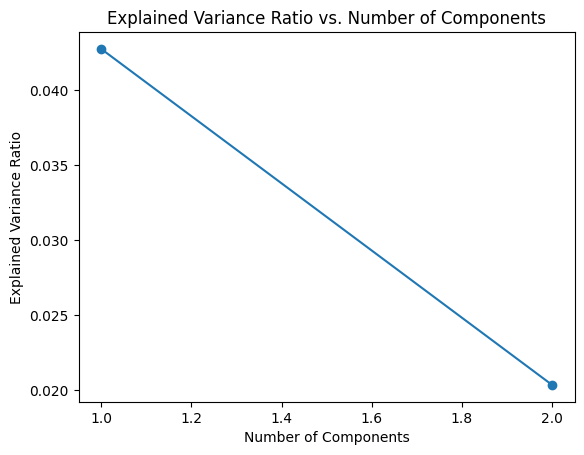

In [11]:
import matplotlib.pyplot as plt
# Plot explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()


In [12]:
pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.8 MB/s eta 0:00:00


In [13]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn import model_selection
from tensorflow.keras.regularizers import L2

In [14]:
import numpy as np

def calculate_sxgbg_features(evolutionary_profile, X):
    L, _ = evolutionary_profile.shape
    sxgbg_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            sxgbg_value = 0.0
            for l in range(1,L - X):
                sxgbg_value += evolutionary_profile[l-1, i] * evolutionary_profile[l + X , j]
            sxgbg_matrix[i, j] = sxgbg_value
    return sxgbg_matrix

In [15]:
sxgbg_features=[]
for i in matrix_3d:
  sxgbg_features.append(calculate_sxgbg_features(i,6))

In [16]:
X_train,X_test,Y_train,Y_test=train_test_split(np.array(sxgbg_features),data.iloc[:,2:7],test_size=0.2,random_state=42)

In [17]:
from tensorflow import keras

model3 = keras.Sequential([
    keras.layers.Input(shape=(20, 20)),  # Adjust input shape to match your data
    keras.layers.Flatten(),  # Flatten the input data
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='sigmoid')  # 5 output nodes for multi-label classification
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    baseline=None,
    restore_best_weights=True
)

In [19]:
history=model3.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=[X_test, Y_test],callbacks=[early_stopping],use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 3s 69ms/step - loss: 0.5741 - accuracy: 0.3636 - val_loss: 0.4626 - val_accuracy: 0.4828
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.4377 - accuracy: 0.5628 - val_loss: 0.4513 - val_accuracy: 0.4310
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.4095 - accuracy: 0.5996 - val_loss: 0.4187 - val_accuracy: 0.5431
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3913 - accuracy: 0.6169 - val_loss: 0.4320 - val_accuracy: 0.4741
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.3677 - accuracy: 0.6212 - val_loss: 0.3837 - val_accuracy: 0.6121
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3303 - accuracy: 0.6797 - val_loss: 0.3925 - val_accuracy: 0.6293
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3225 - accuracy: 0.6667 - val_loss: 0.3609 - val_accuracy: 0.6034
Epoch 8/100
8/8 [===

In [20]:
y_pred=np.round(model3.predict(X_test))

4/4 [==============================] - 0s 3ms/step


In [21]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test,y_pred)
print(accuracy)

0.47413793103448276


In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

# Load your data and perform any necessary preprocessing steps here

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(matrix_2d, data.iloc[:, 2:7], test_size=0.3, random_state=42)

# Create a more complex neural network model
model = Sequential()
model.add(Input(shape=(max_columns,)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))  # 5 output nodes for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[AUC()])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), callbacks=[early_stopping])

# # Evaluate the model
# Y_pred = model.predict(X_test)

# # You can print a classification report for a more detailed analysis
# print(classification_report(Y_test, Y_pred > 0.5))

# # You can also print confusion matrices for each label
# print(multilabel_confusion_matrix(Y_test, Y_pred > 0.5))


Epoch 1/100
7/7 [==============================] - 13s 2s/step - loss: 0.5825 - auc: 0.6223 - val_loss: 0.4436 - val_auc: 0.7492
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 0.5377 - auc: 0.7056 - val_loss: 0.4347 - val_auc: 0.7985
Epoch 3/100
7/7 [==============================] - 13s 2s/step - loss: 0.4777 - auc: 0.7617 - val_loss: 0.4143 - val_auc: 0.8132
Epoch 4/100
7/7 [==============================] - 5s 745ms/step - loss: 0.4559 - auc: 0.7704 - val_loss: 0.4060 - val_auc: 0.8309
Epoch 5/100
7/7 [==============================] - 7s 1s/step - loss: 0.4040 - auc: 0.8281 - val_loss: 0.4067 - val_auc: 0.8298
Epoch 6/100
7/7 [==============================] - 11s 1s/step - loss: 0.3506 - auc: 0.8580 - val_loss: 0.4003 - val_auc: 0.8278
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 0.3204 - auc: 0.8850 - val_loss: 0.4152 - val_auc: 0.8219
Epoch 8/100
7/7 [==============================] - 11s 2s/step - loss: 0.2803 - auc: 0.9195 - val_

In [24]:
# Evaluate the model
Y_pred = model.predict(X_test)

# You can print a classification report for a more detailed analysis
print(classification_report(Y_test, Y_pred > 0.5))

# You can also print confusion matrices for each label
print(multilabel_confusion_matrix(Y_test, Y_pred > 0.5))

6/6 [==============================] - 1s 132ms/step
              precision    recall  f1-score   support

           0       0.47      0.77      0.58        57
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        30
           4       0.70      0.53      0.60        79

   micro avg       0.56      0.48      0.51       181
   macro avg       0.23      0.26      0.24       181
weighted avg       0.45      0.48      0.45       181
 samples avg       0.49      0.48      0.49       181

[[[ 67  50]
  [ 13  44]]

 [[169   0]
  [  5   0]]

 [[164   0]
  [ 10   0]]

 [[144   0]
  [ 30   0]]

 [[ 77  18]
  [ 37  42]]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
